# Imports

In [38]:
import zipfile
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split


# Load in Data

In [ ]:
# Data extration
with zipfile.ZipFile("Alex.zip") as z:
    z.extractall("alex_data")

with zipfile.ZipFile("Kelly.zip") as z:
    z.extractall("kelly_data")


After loading each folder, I created a new folder in the environment called "data" and put both the alex_data and kelly_data into that.

In [ ]:
# Transforms the images into tensors which is the data structure for PyTorch
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")), # ensures each images has RGB components
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder("data", transform = transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

I resized each of the images to 224 x 224 but we can adjust this if needed. I read that each of the images should be the same size but I'm not too sure how much data we are using by downsizing the images.

The batch size is the number of samples in one batch which we can change if we need. In the network, it will process 32 images at a time, update the weights, then move to the next 32 images.

# Inspect image properties

In [16]:
img_tensor, label = dataset[0]
print(img_tensor.shape)        
print(img_tensor.min(), img_tensor.max())  


torch.Size([3, 224, 224])
tensor(0.0353) tensor(0.8431)


3 is the number of channels. In this case it is (R, G, B)

224 x 224 is the height x width of the image

Also shows the min amd max pixel values and they are normalized to [0,1]

In [ ]:
images, labels = next(iter(loader))

img = images[0]
print(img.shape)

r, g, b = img[:, 100, 150]
print("R:", r.item(), "G:", g.item(), "B:", b.item())

torch.Size([32, 3, 224, 224])
torch.Size([3, 224, 224])
R: 0.30980393290519714 G: 0.2666666805744171 B: 0.2862745225429535


First line: 3 is the RGB channels, 224 x 224 is the size of the image

Second line: The RGB values for a specific pixel in image 0. The values are between 0 and 1 because of ToTensor()

# Verifying the data

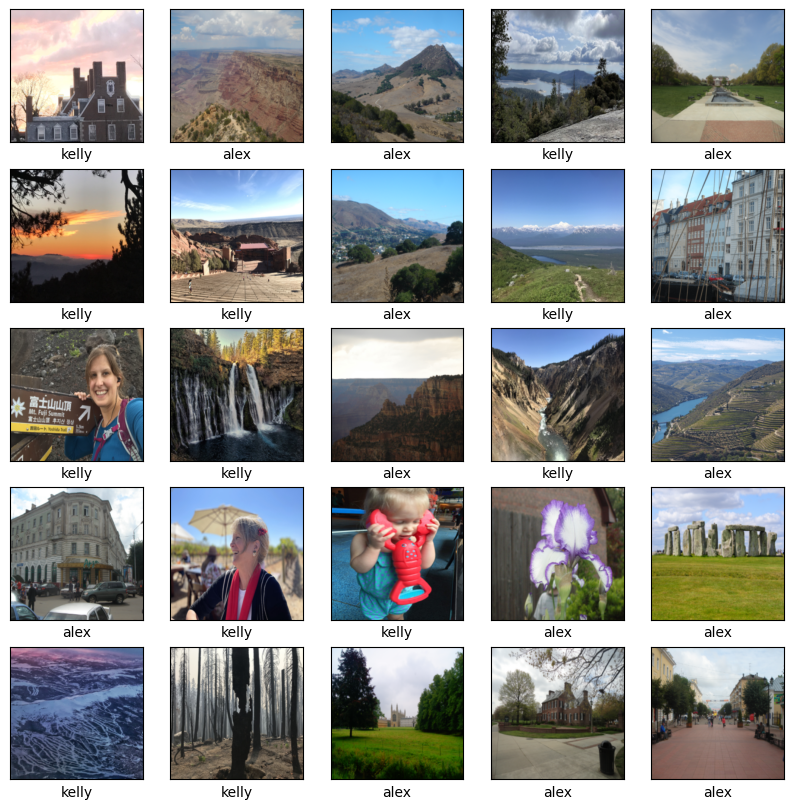

In [ ]:
class_names = ['alex', 'kelly']

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # convert the tensor into HVC for matplotlib
    img = images[i].permute(1, 2, 0).numpy() 

    plt.imshow(img)
    plt.xlabel(class_names[labels[i].item()])
plt.show()

This is just to check what the photos looks like after being resized and we can determine if we need to adjust the dimensions. This was also to check if the label for each photo is correct which they look like they are.

# Simple CNN

In [34]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # 3 input channels and outputs 16 feature maps
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, padding = 1)

        # 16 -> 32 channels
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, padding = 1)

        # Max pooling, downample by 2
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(32 * 56 * 56, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # (B, 16, 112, 112)
        x = self.pool(F.relu(self.conv2(x))) # (B, 32, 56, 56)
        x = x.view(x.size(0), -1) # flatten
        x = self.fc1(x) # (B, 2)
        return x

In [40]:
model = SimpleCNN()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

n = len(dataset)
train_n = int(0.8 * n)
val_n = n - train_n

train, val = random_split(dataset, [train_n, val_n])
train_loader = DataLoader(train, batch_size=32, shuffle=True)
val_loader = DataLoader(val, batch_size=32, shuffle=True)

for epoch in range(5):
    model.train()
    train_loss = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total

    print(
        f"Epoch {epoch+1}, "
        f"Train Loss: {train_loss/len(train_loader):.4f}, "
        f"Val Loss: {val_loss/len(val_loader):.4f}, "
        f"Val Acc: {val_acc:.3f}"
    )

Epoch 1, Train Loss: 15.3511, Val Loss: 0.6623, Val Acc: 0.546
Epoch 2, Train Loss: 0.7705, Val Loss: 0.6793, Val Acc: 0.495
Epoch 3, Train Loss: 0.6920, Val Loss: 0.6740, Val Acc: 0.454
Epoch 4, Train Loss: 0.6923, Val Loss: 0.6774, Val Acc: 0.454
Epoch 5, Train Loss: 0.6869, Val Loss: 0.6836, Val Acc: 0.454
